In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_theme("notebook")
sns.set_style("whitegrid")
sns.set_palette("Dark2")

# Постановка задачи и загрузка данных

В рамках лабораторной работы поработаем снова с реальными данными, содержательно близкими к данным минус первой лабораторной, - про учебные дисциплины. В этот раз займемся обработкой и генерацией описания и содержания дисциплин с помощью языковых моделей.

## Данные

Расположены по ссылке.

In [ ]:
!gdown 1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1

Downloading...
From: https://drive.google.com/uc?id=1k1drlKxdqLgw_y_iMgSkBuZwa2Gjc6Q1
To: /content/disciplines_2018_2022.csv
100% 78.8M/78.8M [00:00<00:00, 214MB/s]


Из информации о дисциплине у нас есть следующая:
1. `course_id` - номер дисциплины (может повторяться)
2. `course_title` - название дисциплины
3. `description` - краткое описание дисциплины
4. `up_id` - айди учебного плана (образовательной прогарммы)
5. `up_title` - название учебного плана (образовательной прогарммы)
6. `qualification` - уровень образования (бакалавриат или магистратура)
7. `start_year` - год набора
8. `module_name` - название модуля, в который входит дисциплина
9. `contents` – содержание дисциплины (все темы и разделы не по порядку, сплошным текстом)

Данные уже частично предобработаны: датасет содержит только те дисциплины, которые реализовывались более одного года. Это примерно треть от всех дисциплин за 2018–2022 гг.

In [ ]:
df = pd.read_csv("/content/disciplines_2018_2022.csv")
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,Инновационный маркетинг. Корпоративные финансы...
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"Математические модели сигналов, помех и канало..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,Особенности организации массовых мероприятий.....


In [ ]:
df.shape

(20502, 9)

Немного погрузимся в данные.

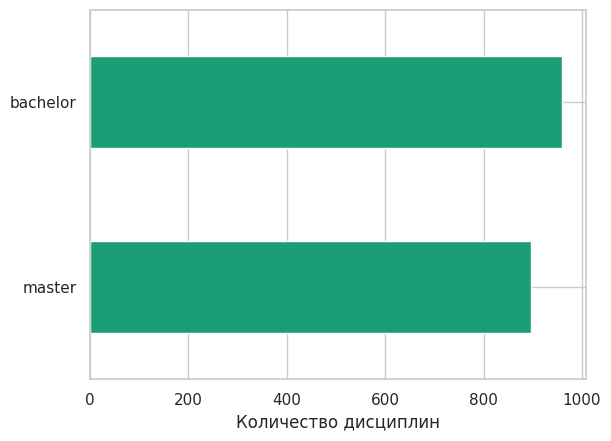

In [ ]:
# количество дисциплин с уникальными названиями по уровням подготовки
df[["course_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество дисциплин")
plt.ylabel("")
plt.show()

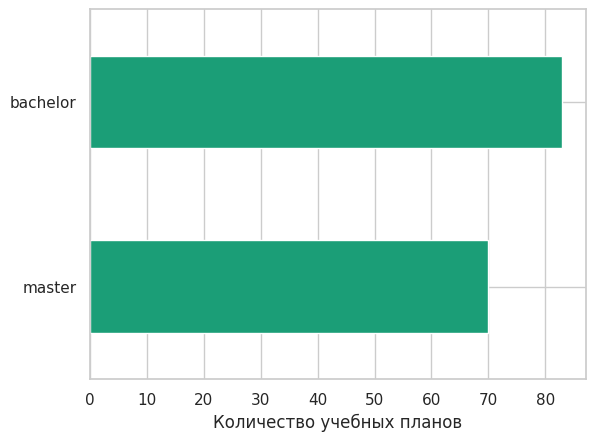

In [ ]:
# количество учебных планов с уникальными названиями по уровням подготовки
df[["up_title", "qualification"]].drop_duplicates().qualification.value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Количество учебных планов")
plt.ylabel("")
plt.show()

Видим, что дисциплин больше (незначительно) в бакалавриате, но учебных планов больше в магистратуре. Это соответствует истине.

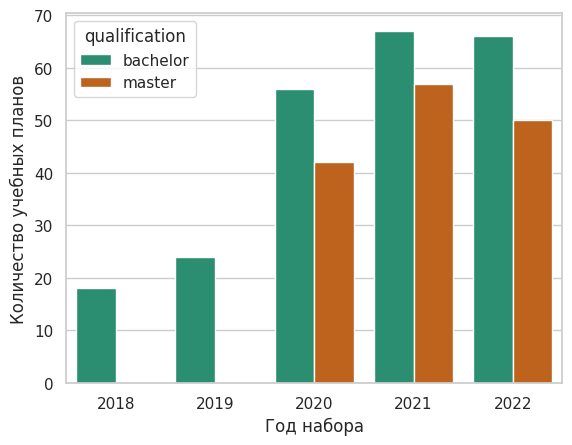

In [ ]:
# количество учебных планов по годам и квалификациям
sns.barplot(data=df[["up_title", "qualification", "start_year"]].drop_duplicates().groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="up_title", hue="qualification")
plt.ylabel("Количество учебных планов")
plt.xlabel("Год набора")
plt.show()

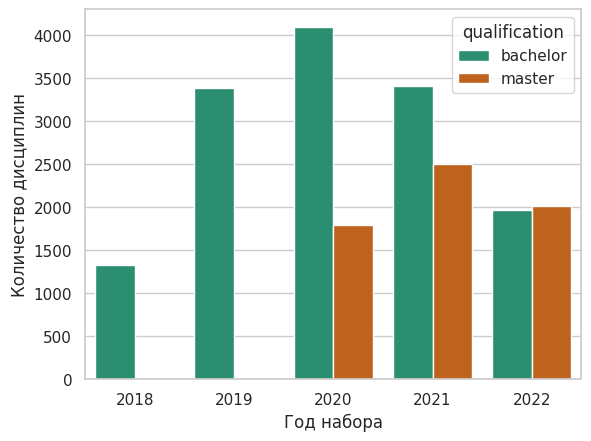

In [ ]:
# количество дисциплин по годам и квалификациям
sns.barplot(data=df[["course_title", "qualification", "start_year"]].groupby(["start_year", "qualification"]).count().reset_index(), x="start_year", y="course_title", hue="qualification")
plt.ylabel("Количество дисциплин")
plt.xlabel("Год набора")
plt.show()

- Данные по магистратуре начали храниться с 2020 года, по бакалавриату – с 2018, поэтому графики выглядит именно так.
- Учебные планы могут существовать несколько лет с одним и тем же названием (как и дисциплины), поэтому в разрезе по годам уникальных записей больше, чем без него.

## Задача 1 – Предобработать description и contents
1. Выполнить предобработку текстовых данных. Минимально понадобятся следующие шаги предобработки:
  - приведение к одному регистру
  - токенизация
  - удаление пунктуации (можно оставить только буквенные символы в текстах)
  - лемматизация (можно использовать pymystem, он менее точный, чем pymorphy2, но работает в несколько раз быстрее)
2. Построить для дисциплины вектор на основе word2vec
3. Потестировать текстовые представления

Задач не много, но некоторые затратные по времени.

Для предобработки можно воспользовать материалами:
- https://colab.research.google.com/drive/1Lxe0_dPxF5_nNC1hnHTRc01rnMmUVCXa?usp=sharing
- https://colab.research.google.com/drive/16EFOsDbaTF2128kkVMqXxx2Xnb7Gr4mW?usp=share_link

### Предобработка текстовых данных

Проведите предобработку для столбца `contents`.

In [ ]:
import nltk
from nltk.corpus import stopwords
import re
from pymystem3 import Mystem


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

m = Mystem()

russian_stopwords = stopwords.words("russian")
# приведение к нижнему регистру и токенизация
df["contents"] = df["contents"].apply(lambda x: x.lower()).apply(nltk.word_tokenize)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
df["contents"] = df["contents"].apply(lambda x: [word for word in x if word.isalpha()])
df["contents"] = df["contents"].apply(lambda x: [word for word in x if word not in russian_stopwords])

In [ ]:
df["contents"] = df["contents"].apply(lambda x: [m.lemmatize(word)[0] for word in x])

In [ ]:
df['contents'].values
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents
16112,17498,Создание технологического бизнеса,Цель курса - предоставить возможность магистра...,7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,"[инновационный, маркетинг, корпоративный, фина..."
2457,3002,Теория электрической связи,Программа составлена в соответствии с требован...,6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"[математический, модель, сигнал, помеха, канал..."
1077,2736,Организация массовых мероприятий,Данная дисциплина учит планировать мероприятие...,6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,"[особенность, организация, массовый, мероприят..."


Проведите предобработку для столбца `description`.

In [ ]:
#df["description"] = df["description"].apply(lambda x: x.lower()).apply(nltk.word_tokenize)
df["description"] = df["description"].apply(lambda x: x.lower()).apply(nltk.word_tokenize)
df["description"] = df["description"].apply(lambda x: [word for word in x if word.isalpha()])
df["description"] = df["description"].apply(lambda x: [word for word in x if word not in russian_stopwords])
df["description"] = df["description"].apply(lambda x: [m.lemmatize(word)[0] for word in x])

In [ ]:
# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents
16112,17498,Создание технологического бизнеса,"[цель, курс, предоставлять, возможность, магис...",7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,"[инновационный, маркетинг, корпоративный, фина..."
2457,3002,Теория электрической связи,"[программа, составлять, соответствие, требован...",6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"[математический, модель, сигнал, помеха, канал..."
1077,2736,Организация массовых мероприятий,"[данный, дисциплина, учить, планировать, мероп...",6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,"[особенность, организация, массовый, мероприят..."


Данные минимально предобработаны. Можно переходить к векторизации. Рассмотрим два подхода:
- Word2Vec, обученный на предобработанных данных
- Tiny BERT – предобученная мини-версия мультиязычного BERT

### Кратко про языковые модели

Вне зависомости от того, большая модель или нет, данные, на которых она обучается и тестируется проходят одинаковые этапы предобработки.

Перед тем как начать обучение модели, необходимо подготовить текстовые данные. Этот процесс включает несколько этапов:

-	**Сбор данных.**

Модель обучается на большом корпусе текстов, который может включать книги, статьи, блоги, форумы и другие источники. Чем больше и разнообразнее данные, тем лучше модель сможет понять и воспроизвести язык.
-	**Токенизация.**

Процесс разбиения текста на отдельные элементы, называемые токенами. Токены могут представлять собой слова, части слов или даже отдельные символы. Например, фраза «Как дела?» может быть токенизирована как [«Как», «дела», «?»].
-	**Создание словарей.**

После токенизации формируется словарь, который сопоставляет с каждым токеном уникальный идентификатор. Этот словарь необходим для перевода текстовых данных в числовую форму, понятную модели.
-	**Преобразование текста в числовые векторы.**

Токены преобразуются в числовые векторы, которые будут использоваться в качестве входных данных для нейронной сети. Эти векторы могут быть статическими, как в Word2Vec, или динамическими, как в трансформерах.

---
Обучение языковой модели заключается в настройке её параметров на основе текстовых данных, чтобы она могла предсказывать следующее слово или генерировать осмысленные фразы.

-	**Forward propagation (прямой проход).**

На этом этапе данные проходят через слои нейронной сети, где каждое слово представляется в виде вектора. Эти векторы затем преобразуются в промежуточные состояния, которые несут информацию о контексте текста.
-	**Механизм внимания.**

В современных моделях, таких как трансформеры, используется механизм внимания, который позволяет модели выделять наиболее важные части текста, на которых нужно сосредоточиться при генерации или предсказании.
-	**Обратное распространение ошибки (Backpropagation).**

После того как модель сделала предсказание, она сравнивает его с реальными данными и вычисляет ошибку. Затем эта ошибка используется для корректировки параметров модели, чтобы улучшить точность предсказаний в будущем.
-	**Обучение на основе батчей.**

Данные разбиваются на небольшие группы — батчи, которые подаются модели для обучения. Этот метод позволяет эффективно использовать вычислительные ресурсы и ускорять процесс обучения.

Трансформеры
Современные языковые модели в большинстве основаны на архитектуре трансформеров, предложенной в 2017 году. Трансформеры решают многие проблемы, присущие RNN, и становятся доминирующим подходом в NLP.

-	**BERT (Bidirectional Encoder Representations from Transformers).**

Модель BERT использует двунаправленное обучение, что позволяет ей понимать контекст слова как слева, так и справа от него. Это делает BERT особенно мощным инструментом для задач, связанных с пониманием текста, таких как вопросо-ответные системы и анализ тональности.
-	**GPT (Generative Pre-Trained Transformer).**

Модель GPT, напротив, использует однонаправленное обучение, предсказывая следующее слово только на основе предыдущих слов. Эта модель, особенно в версиях GPT-2 и GPT-3, стала чрезвычайно популярной для генерации текста благодаря своей способности создавать связные и осмысленные сообщения, которые трудно отличить от текстов, написанных человеком.

### Векторизация word2vec

In [ ]:
from gensim.models import Word2Vec
import gensim

In [ ]:
w2v_model = Word2Vec(df['description'].values, min_count=1, vector_size=300, workers=2, window=10)

In [ ]:
w2v_model_path = "w2v.bin" # будет удобно сохранить модель, если выполняете лабу не за один вечер
w2v_model.save(w2v_model_path)

In [ ]:
# загрузка сохраненной модели
w2v_model = gensim.models.Word2Vec.load(w2v_model_path)

In [ ]:
# так выглядит один вектор
print(w2v_model.wv.get_vector("обучение").shape)  # размер вектора
w2v_model.wv.get_vector("обучение")

(300,)


array([-1.9764249 , -0.3148521 ,  0.86283803,  0.38211322, -1.6494174 ,
        0.808504  ,  0.2968943 ,  0.15558365, -0.34277847, -2.1186948 ,
        1.0069656 ,  1.5660542 , -0.2735026 ,  0.9999011 , -1.3573552 ,
        0.9945812 ,  1.3751925 ,  0.35372663, -3.0358465 ,  0.90522575,
        0.0100038 ,  0.2746457 ,  1.4279094 , -1.1590664 ,  1.4374939 ,
       -2.3477895 , -1.4689469 , -0.20089424,  2.9142864 ,  0.71308184,
        0.13721201, -0.68287224,  0.863072  ,  0.30154818,  0.57193124,
        1.6164094 ,  0.11632943, -0.850628  ,  1.2769145 ,  1.6663711 ,
        0.4995229 ,  1.1258094 ,  1.1355445 , -0.27497494, -0.6964487 ,
       -1.9422803 , -1.6092864 , -1.7212946 ,  0.03566013,  1.9010665 ,
       -0.23913817,  0.23143917,  1.381864  ,  0.4367728 ,  0.6759489 ,
       -0.97076035,  0.23338144, -1.9724506 ,  0.31059933,  1.1107321 ,
        1.1867929 , -0.30480245, -1.5465535 , -2.3021634 , -3.0037704 ,
       -1.8414984 ,  3.2065442 ,  0.6564936 ,  0.5551058 , -2.03

In [ ]:
# слова, максимально близкие к "машинному обучению"
w2v_model.wv.most_similar(["обучение", "машинный"])

[('ия', 0.7619263529777527),
 ('искусственный', 0.587203323841095),
 ('непосредственно', 0.5310849547386169),
 ('трудиться', 0.5285180807113647),
 ('код', 0.4820408821105957),
 ('нейронный', 0.4777420461177826),
 ('продвигать', 0.47183871269226074),
 ('совершенствование', 0.4701355993747711),
 ('автоматический', 0.467190682888031),
 ('just', 0.4644845128059387)]

In [ ]:
# слова, максимально близкие к "анализу данных"
w2v_model.wv.most_similar(["анализ", "данные"])

[('редактор', 0.5691972374916077),
 ('востребовать', 0.5628970265388489),
 ('кандидат', 0.5628810524940491),
 ('анализировать', 0.5579091310501099),
 ('совершенствовать', 0.5507048964500427),
 ('графический', 0.5214715600013733),
 ('обезопасить', 0.5153514742851257),
 ('экспериментальный', 0.5088531970977783),
 ('обрабатывать', 0.5050047636032104),
 ('нужный', 0.4969128370285034)]

Семантически получились не идеальные, но в целом близкие списки. Это естественно, т.к. уникальных записей для обучения было передано около 2000.

Создадим два вектора для каждой дисциплины:
1. По данным содержания (`contents`)
2. По данным описание дисциплины (`description`)

Учитывайте, что должна быть возможность построить эмбеддинг для нового текста, даже если некоторые слова отсутствуют в исходной модели. При этом вектор не должен быть нулевым. Для этого напишите функцию `embed()`, в качестве агрументов принимающую список токенов текста и модель.

Вектором текста должно являться среднее всех векторов слов текста.

In [ ]:
import numpy as np

def embed(tokenized_text, model):
  vectors = []
  for token in tokenized_text:
    try:
      vectors.append(model.wv.get_vector(token))
    except KeyError:
      continue

  if vectors:
    return np.mean(vectors, axis=0)
  else:
    return np.zeros(model.vector_size)

df['contents_embedding'] = df['contents'].apply(lambda x: embed(x, w2v_model))
df['description_embedding'] = df['description'].apply(lambda x: embed(x, w2v_model))


Теперь применим функцию `embed()` для формирования вектора для содержаний и кратких описаний в каждой записи.

In [ ]:
# ваш код здесь

# пример результата
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_embedding,description_embedding
16112,17498,Создание технологического бизнеса,"[цель, курс, предоставлять, возможность, магис...",7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,"[инновационный, маркетинг, корпоративный, фина...","[0.13246696, 0.021929316, 0.053582605, -0.2374...","[0.016304526, 0.18489207, -0.4006448, 0.052697..."
2457,3002,Теория электрической связи,"[программа, составлять, соответствие, требован...",6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"[математический, модель, сигнал, помеха, канал...","[0.26220888, -0.31241402, 0.04154167, -0.06955...","[0.26199496, -0.009596102, 0.3307315, -0.16777..."
1077,2736,Организация массовых мероприятий,"[данный, дисциплина, учить, планировать, мероп...",6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,"[особенность, организация, массовый, мероприят...","[-0.0964223, -0.124466866, -0.14277768, -0.233...","[0.024532001, 0.057297226, -0.11548535, 0.0999..."


Оценим, насколько семантически близки краткие описания дисциплин и темы в содержании. Для оценки воспользуемся косинусным сходством.

$$K(X, Y) = \frac{X \cdot Y} {||X||*||Y||}$$

В `sklearn` функция для расчета косинусного сходства генерирует матрицу результатов, мы будем сравнивать всего два вектора, поэтому напишем свою обертку для функции из `sklearn` так, чтобы она возвращала одно числовое значение, а не матрицу.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_wrapper(v1, v2):
  return cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1))[0][0]

df['similarity'] = df.apply(lambda row: cosine_similarity_wrapper(row['contents_embedding'], row['description_embedding']), axis=1)

df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_embedding,description_embedding,similarity
16112,17498,Создание технологического бизнеса,"[цель, курс, предоставлять, возможность, магис...",7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,"[инновационный, маркетинг, корпоративный, фина...","[0.13246696, 0.021929316, 0.053582605, -0.2374...","[0.016304526, 0.18489207, -0.4006448, 0.052697...",0.645796
2457,3002,Теория электрической связи,"[программа, составлять, соответствие, требован...",6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"[математический, модель, сигнал, помеха, канал...","[0.26220888, -0.31241402, 0.04154167, -0.06955...","[0.26199496, -0.009596102, 0.3307315, -0.16777...",0.587612
1077,2736,Организация массовых мероприятий,"[данный, дисциплина, учить, планировать, мероп...",6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,"[особенность, организация, массовый, мероприят...","[-0.0964223, -0.124466866, -0.14277768, -0.233...","[0.024532001, 0.057297226, -0.11548535, 0.0999...",0.830712


Оценим по графику распределение сходств для всех дисциплин. Должен получиться график, похожий на гистограмму ниже. Пунктиром обозначено медианное значение.

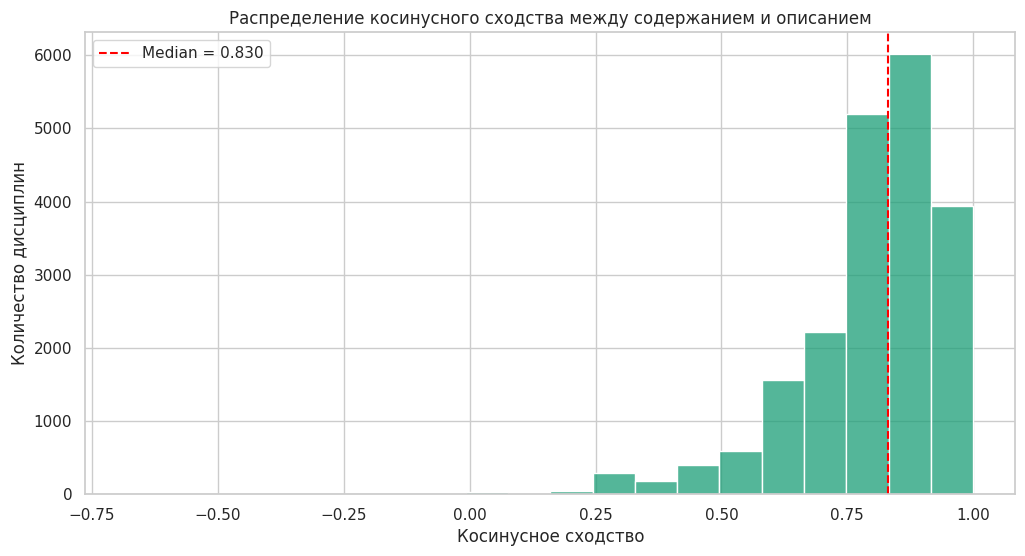

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['similarity'], bins=20)
plt.axvline(df['similarity'].median(), color='red', linestyle='--', label=f"Median = {df['similarity'].median():.3f}")
plt.xlabel("Косинусное сходство")
plt.ylabel("Количество дисциплин")
plt.title("Распределение косинусного сходства между содержанием и описанием")
plt.legend()
plt.show()

### Векторизация Tiny BERT

В качестве предобученной модели воспользуемся Tiny BERT – https://huggingface.co/sergeyzh/rubert-tiny-turbo

Она априори менее точная, чем базовый BERT, но строит эмбеддинги в разы быстрее.

In [ ]:
from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer('sergeyzh/rubert-tiny-turbo')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/431k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/196 [00:00<?, ?B/s]

> Если вы выполняете эту лабораторную локально, то возможны конфликты версии `sentence_transformers` и `tensorflow`, обычно решающиеся даунгрейдом `tensorflow`.

Прежде чем формировать эмбеддинги, объединим список токенов в строку.

In [ ]:
# ваш код здесь

# пример результата преобразования
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_embedding,description_embedding,similarity
16112,17498,Создание технологического бизнеса,"[цель, курс, предоставлять, возможность, магис...",7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,"[инновационный, маркетинг, корпоративный, фина...","[0.13246696, 0.021929316, 0.053582605, -0.2374...","[0.016304526, 0.18489207, -0.4006448, 0.052697...",0.645796
2457,3002,Теория электрической связи,"[программа, составлять, соответствие, требован...",6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"[математический, модель, сигнал, помеха, канал...","[0.26220888, -0.31241402, 0.04154167, -0.06955...","[0.26199496, -0.009596102, 0.3307315, -0.16777...",0.587612
1077,2736,Организация массовых мероприятий,"[данный, дисциплина, учить, планировать, мероп...",6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,"[особенность, организация, массовый, мероприят...","[-0.0964223, -0.124466866, -0.14277768, -0.233...","[0.024532001, 0.057297226, -0.11548535, 0.0999...",0.830712


Чтобы не генерировать несколько раз одинаковые векторы (в данных много неуникальных описаний и содеражний), оставим только уникальные, а затем присоединим их в исходную таблицу. Уникальных записей в разрезе описания и содержания около 2500.

>`tqdm.auto` позволяет в удобном формате добавлять прогресс-бар к некоторым методам `pandas` – например, `apply`, и получать метод `progress_apply`.

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

df['unique_id'] = df.apply(lambda row: hash(tuple(' '.join(row[col]) for col in ['description', 'contents'])), axis=1)

df_unique = df.drop_duplicates(subset='unique_id').copy()

df_unique['contents_embedding_bert'] = df_unique['contents'].progress_apply(lambda x: bert_model.encode(' '.join(x)))
df_unique['description_embedding_bert'] = df_unique['description'].progress_apply(lambda x: bert_model.encode(' '.join(x)))

df = pd.merge(df, df_unique[['unique_id', 'contents_embedding_bert', 'description_embedding_bert']], on='unique_id', how='left')

  0%|          | 0/2529 [00:00<?, ?it/s]

  0%|          | 0/2529 [00:00<?, ?it/s]

Теперь присоедините полученную таблицу в исходный датафрейм.

In [ ]:
print(df.shape)
df.sample(3, random_state=42)

(20502, 15)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_embedding,description_embedding,similarity,unique_id,contents_embedding_bert,description_embedding_bert
16112,17498,Создание технологического бизнеса,"[цель, курс, предоставлять, возможность, магис...",7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,"[инновационный, маркетинг, корпоративный, фина...","[0.13246696, 0.021929316, 0.053582605, -0.2374...","[0.016304526, 0.18489207, -0.4006448, 0.052697...",0.645796,2910558751469792136,"[-0.023438891, -0.024771137, 0.020273432, -0.0...","[0.018932614, -0.031260785, 0.03172312, 0.0184..."
2457,3002,Теория электрической связи,"[программа, составлять, соответствие, требован...",6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"[математический, модель, сигнал, помеха, канал...","[0.26220888, -0.31241402, 0.04154167, -0.06955...","[0.26199496, -0.009596102, 0.3307315, -0.16777...",0.587612,6142523777146115409,"[-0.01740429, 0.01110584, 0.061533373, -0.0136...","[0.036315396, -0.0207421, 0.027428193, -0.0115..."
1077,2736,Организация массовых мероприятий,"[данный, дисциплина, учить, планировать, мероп...",6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,"[особенность, организация, массовый, мероприят...","[-0.0964223, -0.124466866, -0.14277768, -0.233...","[0.024532001, 0.057297226, -0.11548535, 0.0999...",0.830712,-8662292739449036204,"[0.017201137, -0.004298017, 0.012148312, -0.02...","[0.034545876, -0.008536334, -0.00068462203, 0...."


In [ ]:
# размер вектора Tiny BERT – 312, что близко к размеру векторов w2v
df.contents_embedding_bert[0].shape

(312,)

Повторим эксперимент из предыдущего раздела – оценим, насколько схожи векторы описания и содержания для одной дисциплины, сгенерированные BERT.

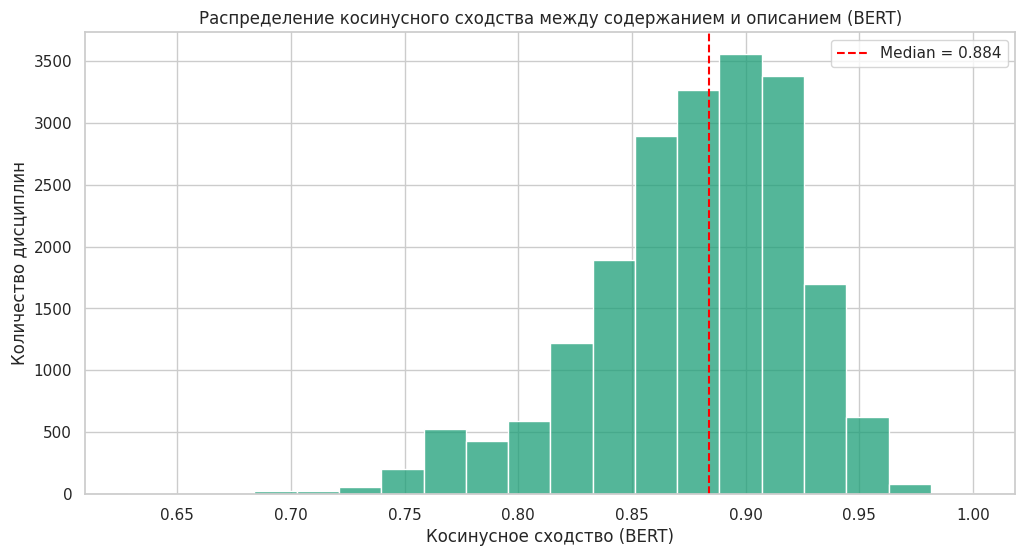

In [ ]:

df['similarity_bert'] = df.apply(lambda row: cosine_similarity_wrapper(row['contents_embedding_bert'], row['description_embedding_bert']), axis=1)



Постройте график. Вероятно, он будет похож на тот, что ниже.

Здесь снова пунктиром обозначена медиана.

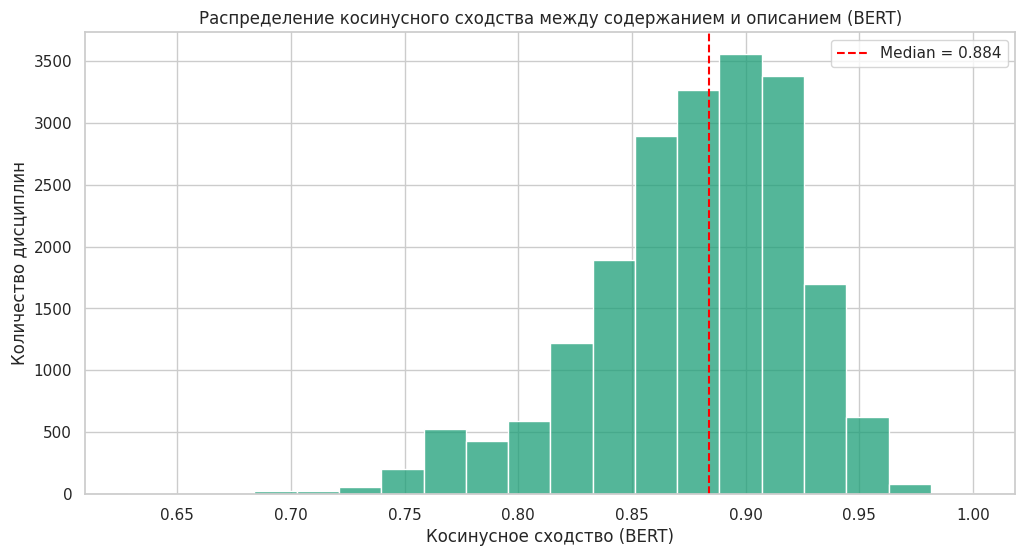

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['similarity_bert'], bins=20)
plt.axvline(df['similarity_bert'].median(), color='red', linestyle='--', label=f"Median = {df['similarity_bert'].median():.3f}")
plt.xlabel("Косинусное сходство (BERT)")
plt.ylabel("Количество дисциплин")
plt.title("Распределение косинусного сходства между содержанием и описанием (BERT)")
plt.legend()
plt.show()

Теперь сравните распределения сходств, полученных при использовании разных подходов к векторизации.

В результате должно получиться нечто похожее на гистограмму ниже. По ней видно, что вектора Tiny BERT дают более узкий диапазон сходств. И более высокие значения. Это можно объяснить тем, что:
- модель обучалась на более широком контексте и не улавливает тонкостей разных дисциплин
- относительно стандартного BERT качество модели сильно ниже (его можно поизучать по ссылке в начале раздела)

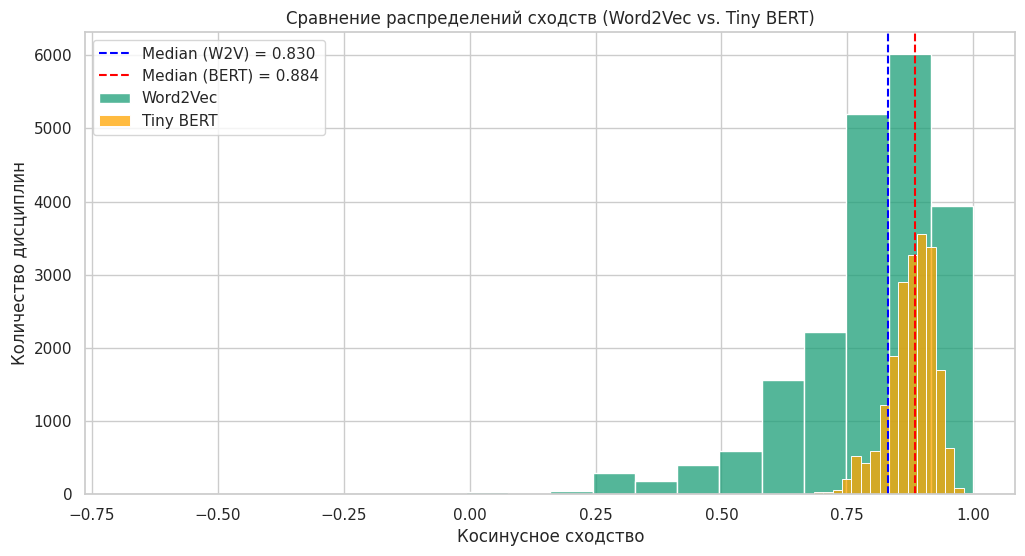

In [ ]:

plt.figure(figsize=(12, 6))
sns.histplot(df['similarity'], bins=20, label='Word2Vec', )
sns.histplot(df['similarity_bert'], bins=20, label='Tiny BERT', color='orange')
plt.axvline(df['similarity'].median(), color='blue', linestyle='--', label=f"Median (W2V) = {df['similarity'].median():.3f}")
plt.axvline(df['similarity_bert'].median(), color='red', linestyle='--', label=f"Median (BERT) = {df['similarity_bert'].median():.3f}")
plt.xlabel("Косинусное сходство")
plt.ylabel("Количество дисциплин")
plt.title("Сравнение распределений сходств (Word2Vec vs. Tiny BERT)")
plt.legend()
plt.show()

## Задача 2 – Сгенерировать description и contents

Задача 2 – исследовательская. Надо проверить, как с работой преподавателя справится большая языковая модель. В исходных данных расположены описания и темы из содержания, написанные реальными людьми. Теперь используем LLM для той же задачи. Также рассмотрим, как разные техники промпт-инжиниринга будут влиять на результат.

### Техники промпт-инжиниринга

Под техникой промпт-инжиниринга (или промптинга) понимается практика разработки и оптимизации промптов (запросов, подсказок) к модели, которые помогут получить максимально близкий к ожидаемому ответ и эффективно взаимодействовать с языковой моделью. Это ключевой элемент в управлении работой и поведением LLM.


Наиболее популярными являются следующие техники:
1. **Zero-shot** (Обучение без примеров) – модель применяет общие знания и правила для решения новых задач.
2. **Few-shot** (Обучение на нескольких примерах) – модель адаптируется к новым задачам, используя небольшой набор примеров.
3. **Chain-of-thought** (Цепочка рассуждений) – модель генерирует пошаговое рассуждение для решения задачи, что помогает в понимании сложных задач и улучшает точность ответов.
4. **Tree of thoughts** (Дерево рассуждений) – подход, при котором рассматриваются различные варианты решений или идей, ветвящиеся от основной мысли.

В этой работе воспользуемся первыми двумя подходами.

В колабе слишком мало ресурсов (если пользоваться бесплатной версией), чтобы хотя бы запустить какую-нибудь интересную современную модель через модуль `transformers`, и тем более ресурсов не хватит для дообучения. Поэтому для тестирования воспользуемся API/serverless API.

Тестировать запросы будем к LLM mistral-nemo-instruct-2407 – https://huggingface.co/mistralai/Mistral-Nemo-Instruct-2407

Это дообученная instruct-версия модели mistral-nemo-base-2407 (12В). Модели категории Instruct способны генерировать ответ, следуя заданному им шаблону поведения.

Обе версии (base и instruct) мультиязычные и выпущены MistralAI и NVIDIA в июле 2024.

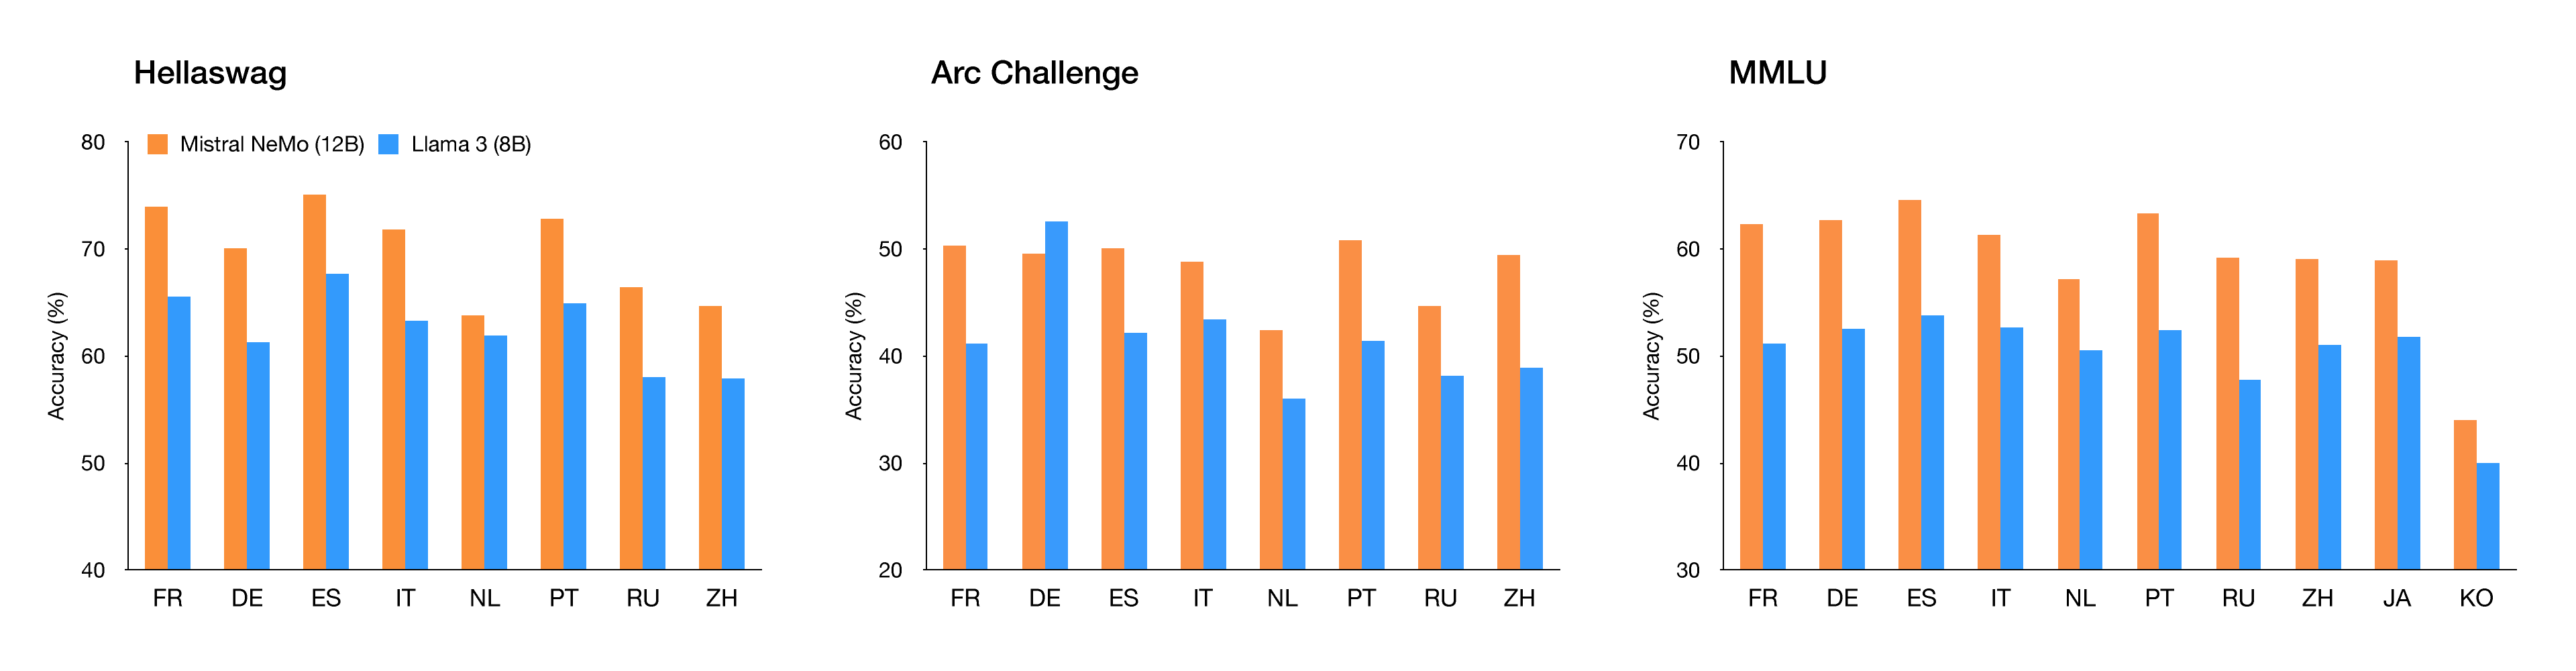

#### zero-shot

Техника промпт-инжиниринга, в которой мы, не давая модели никакой вспомогательной информации, ожидаем от нее ответа на запрос (промпт) в свободной форме.

In [ ]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key="")  # ваш токен с  HuggingFace

Базово запустим модель через serverless API, предоставляемый HuggingFace. Это самый простой способо интегрировать модель в колаб. Для использования в реальных приложениях он не подойдет.

In [ ]:
messages = [
	{
		"role": "user",
		"content": """Ты – преподаватель в университете.
                  Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'.
                  Разделов должно быть не более 8."""
	}
]

completion = client.chat.completions.create(
    model="mistralai/Mistral-Nemo-Instruct-2407",
	  messages=messages,
	  max_tokens=500
)

print(completion.choices[0].message.content)

1. Введение в Python и среду разработки
2. Типы данных и переменные
3. Управляющие конструкции: циклы и условия
4. Функции: определение, вызов и параметры
5. Модули и пакеты
6. exception Handling (обработка ошибок)
7. Введение в NumPy, Pandas и Matplotlib для анализа данных
8. Введение в визуализацию данных с помощью Seaborn и matplotlib


Можно получить что-то адекватное, а можно – что-то такое🤣

>**Текст промпта имеет значение!**

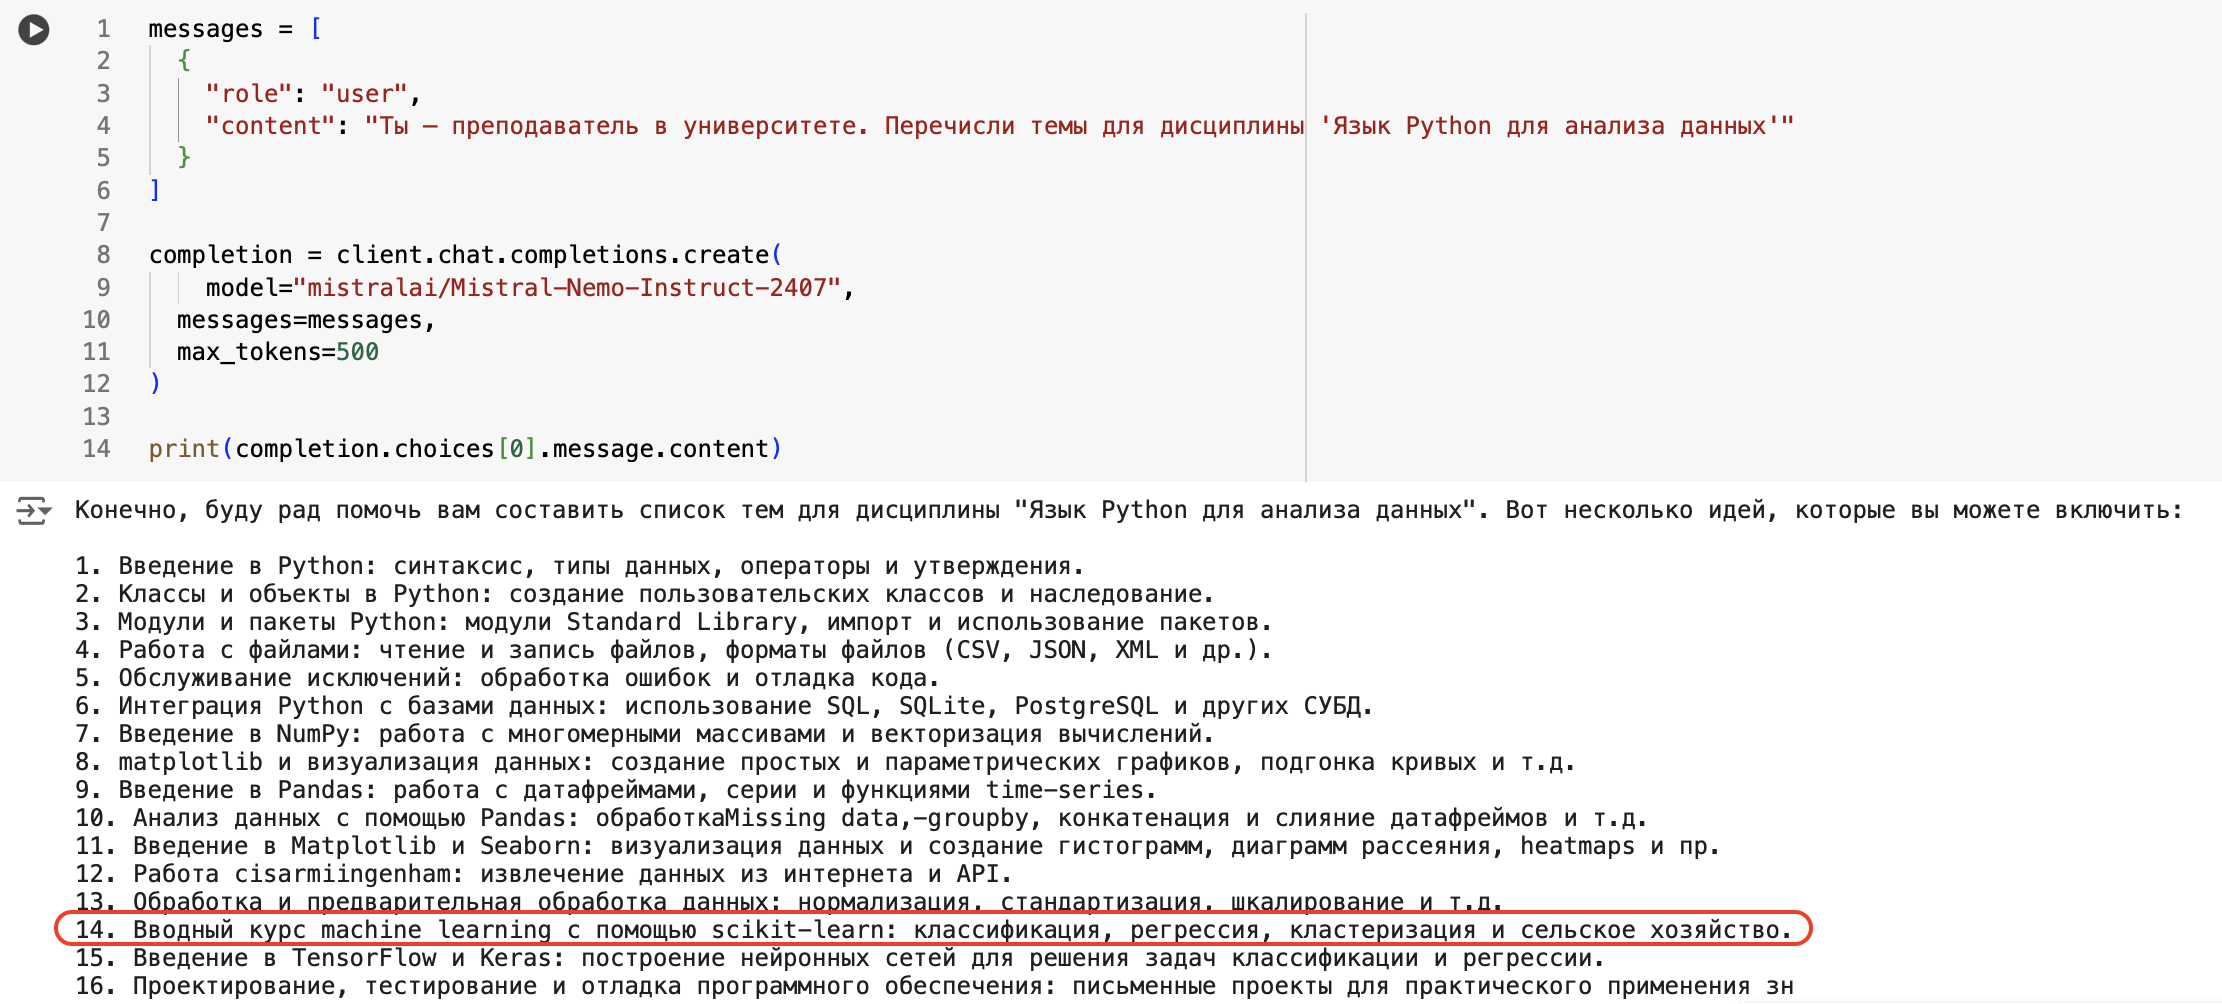

Но параметры API-запросов можно настраивать – https://huggingface.co/docs/api-inference/tasks/chat-completion

Наиболее ценные из них, сокращающие число галлюцинаций модели:
- temperature (температура): варьируется от 0 до 2 – чем выше, тем выше свобода модели в самовыражении и тем случайнее результат. До 0.5 считается низкой, но хорошо поэкспериментировать, чтобы подобрать наиболее адекватный для своей задачи результат.
- top_p – задает планку (долю), по которой отсекаются наименее релевантные ответы для вопроса, 0.1 означает, что для формирования ответа берутся 10% наиболее значимых токенов. Рекомендуется настраивать либо температуру, либо вероятность.

Поработаем с температурой. В качестве примера сгенерируем содержание дисциплины "Язык Python для анализа данных" с температурой от 0 до 2 с шагом 0.1.

In [ ]:
import numpy as np

messages = [
	{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины 'Язык Python для анализа данных'. Разделов должно быть не более 8."
	}
]

temperatures = np.arange(0,2,0.1)

for temp in temperatures:
    print(f"\n{'*'*20} temperature = {temp} {'*'*20}\n")

    completion = client.chat.completions.create(
        model="mistralai/Mistral-Nemo-Instruct-2407",
        messages=messages,
        max_tokens=500,
        temperature=temp
    )

    print(completion.choices[0].message.content)



******************** temperature = 0.0 ********************

1. Введение в Python: основные понятия, синтаксис, типы данных, переменные, операторы, циклы, функции.
2. Модули и пакеты: импорт модулей, работа с пакетами, виртуальные окружения.
3. Работа с файлами: чтение и запись файлов, работа с директориями, исключения при работе с файлами.
4. Коллекции данных: списки, кортежи, словари, множества, работа с коллекциями.
5. Функции высшего порядка: map, filter, reduce, lambda-функции, декораторы.
6. Объектно-ориентированное программирование: классы, объекты, наследование, полиморфизм, инкапсуляция.
7. Работа с датами и временем: модуль datetime, форматирование дат и времени.
8. Введение в NumPy и Pandas: работа с многомерными массивами, сериалами, датафреймами, визуализация данных.

******************** temperature = 0.1 ********************



KeyboardInterrupt: 

Вывод: если температуру выкрутить на максимум, концентрация бреда зашкаливает, перемешиваются языки, генерируютя несуществующие слова; а если занулить, то ответ получается похожий на правду, но очень ограниченный и сухой.
>**Нужно искать такое значение температуры, при котором будет соблюдаться баланс между честностью и свободой творчества.**

В примере выше наиболее интересные результаты получились при температуре от 0.3 до 0.7. Результат на 0.7 наиболее творческий и обширный. В таком примере стоит потестировать несколько температур и повалидировать их генерации.

Попробуем еще пару примеров с другими дисциплинами.

In [ ]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": "Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {}. Разделов должно быть не более 8.".format(course)
	}] for course in courses
]


# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,1,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Машинное обучение. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Современные инструменты для анализа данных. Разделов должно быть не более 8.'}], [{'role': 'user', 'content': 'Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Методы визуализации данных. Разделов должно быть не более 8.'}]]

******************** Машинное обучение: temperature = 0.3 ********************

1. Введение в машинное обучение: определение, история, области применения и преимущества.
2. Математические основы машинного обучения: линейная алгебра, теория вероятностей и статистика.
3. Алгоритмы обучения с учителем: линейная регрессия, логистическая регрессия, деревья решений, случайные леса и поддерживающая вектора машины.
4. Алгоритмы обучения без учителя: кластеризация, ассоциативное правил

KeyboardInterrupt: 

Здесь наиболее интересные ответы получаются при температуре 0.5–0.7. 0.7 ни в одном примере пока не ушли в откровенные галлюцинации.

Теперь сгенерируем содержание для 100 случайных дисциплин. Не будем брать все с целью экономии времени. Если есть время и желание, можно для всех 1757.

In [ ]:
ud = df[["course_title"]].drop_duplicates().sample(100, random_state=42)
ud.shape

(100, 1)

Напишите функцию `mistral_zero_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Альтернативно промпт можно тоже сделать параметром.

In [ ]:
def mistral_zero_shot(course, cli, temp):
  messages = [
	{
		"role": "user",
		"content": f"Ты – преподаватель в университете. Напиши описание для дисциплины '{course}'. Удели внимание содержанию дисциплины."
	}
]
  try:
    completion = cli.chat.completions.create(
    model="mistralai/Mistral-Nemo-Instruct-2407",
    messages=messages,
    max_tokens=500,
    temperature = temp)
    print(completion.choices[0].message.content)
    return completion.choices[0].message.content
  except Exception as e:
    print(e)
    return f"Произошла ошибка: {e}"


Добавьте столбец со сгенерированным содержанием в датафрейм.

In [ ]:
print(mistral_zero_shot('Экологическое аудирование',client,0.6))
df['generated_content'] = ud['course_title'].apply(lambda x: mistral_zero_shot(x, client, 0.5))

Дисциплина "Экологическое аудирование" является важной и актуальной частью экологического образования в современном мире. Ее цель состоит в том, чтобы предоставить студентам необходимые знания и навыки для оценки и анализа экологических последствий хозяйственной деятельности человека, а также для разработки и внедрения эффективных мер по сохранению и восстановлению природной среды.

Содержание дисциплины включает в себя изучение основ экологического аудирования, методов и подходов к его проведению, а также рассмотрение практических примеров из различных отраслей хозяйственной деятельности. В процессе обучения студенты Familiarize themselves с основными принципами экологического права и международными соглашениями, направленными на защиту окружающей среды. Кроме того, они изучают методы оценки воздействия на окружающую среду, системы экологического менеджмента и аудита, а также способы уменьшения экологических рисков и ущерба.

Важной частью дисциплины является изучение современных экол

In [ ]:
# ваш код здесь

# пример результата после добавления столбца с генерацией
print(df.shape)
df.sample(3, random_state=42)

(20502, 17)


,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_embedding,description_embedding,similarity,unique_id,contents_embedding_bert,description_embedding_bert,similarity_bert,generated_content
16112,17498,Создание технологического бизнеса,"[цель, курс, предоставлять, возможность, магис...",7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,"[инновационный, маркетинг, корпоративный, фина...","[0.13246696, 0.021929316, 0.053582605, -0.2374...","[0.016304526, 0.18489207, -0.4006448, 0.052697...",0.645796,2910558751469792136,"[-0.023438891, -0.024771137, 0.020273432, -0.0...","[0.018932614, -0.031260785, 0.03172312, 0.0184...",0.833168,NaN
2457,3002,Теория электрической связи,"[программа, составлять, соответствие, требован...",6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"[математический, модель, сигнал, помеха, канал...","[0.26220888, -0.31241402, 0.04154167, -0.06955...","[0.26199496, -0.009596102, 0.3307315, -0.16777...",0.587612,6142523777146115409,"[-0.01740429, 0.01110584, 0.061533373, -0.0136...","[0.036315396, -0.0207421, 0.027428193, -0.0115...",0.843592,NaN
1077,2736,Организация массовых мероприятий,"[данный, дисциплина, учить, планировать, мероп...",6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,"[особенность, организация, массовый, мероприят...","[-0.0964223, -0.124466866, -0.14277768, -0.233...","[0.024532001, 0.057297226, -0.11548535, 0.0999...",0.830712,-8662292739449036204,"[0.017201137, -0.004298017, 0.012148312, -0.02...","[0.034545876, -0.008536334, -0.00068462203, 0....",0.907226,NaN


Векторизуйте сгенерированное содержание с помощью обоих векторайзеров из предыдущего задания.

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

df['generated_content'] = df['generated_content'].fillna('')
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['generated_content'])

count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(df['generated_content'])

print("TF-IDF matrix shape:", tfidf_matrix.shape)
print("Count matrix shape:", count_matrix.shape)

TF-IDF matrix shape: (20502, 3674)
Count matrix shape: (20502, 3674)


In [ ]:
# пример результата обработки
df.sample(3, random_state=42)

,course_id,course_title,description,up_id,up_title,qualification,start_year,module_name,contents,contents_embedding,description_embedding,similarity,unique_id,contents_embedding_bert,description_embedding_bert,similarity_bert,generated_content
16112,17498,Создание технологического бизнеса,"[цель, курс, предоставлять, возможность, магис...",7198,Информационная безопасность / Information secu...,master,2022,Наукоемкое предпринимательство,"[инновационный, маркетинг, корпоративный, фина...","[0.13246696, 0.021929316, 0.053582605, -0.2374...","[0.016304526, 0.18489207, -0.4006448, 0.052697...",0.645796,2910558751469792136,"[-0.023438891, -0.024771137, 0.020273432, -0.0...","[0.018932614, -0.031260785, 0.03172312, 0.0184...",0.833168,
2457,3002,Теория электрической связи,"[программа, составлять, соответствие, требован...",6989,Программирование в инфокоммуникационных системах,bachelor,2020,Модуль обязательных дисциплин,"[математический, модель, сигнал, помеха, канал...","[0.26220888, -0.31241402, 0.04154167, -0.06955...","[0.26199496, -0.009596102, 0.3307315, -0.16777...",0.587612,6142523777146115409,"[-0.01740429, 0.01110584, 0.061533373, -0.0136...","[0.036315396, -0.0207421, 0.027428193, -0.0115...",0.843592,
1077,2736,Организация массовых мероприятий,"[данный, дисциплина, учить, планировать, мероп...",6875,Управление технологическими инновациями,bachelor,2018,Модуль «Soft Skills»,"[особенность, организация, массовый, мероприят...","[-0.0964223, -0.124466866, -0.14277768, -0.233...","[0.024532001, 0.057297226, -0.11548535, 0.0999...",0.830712,-8662292739449036204,"[0.017201137, -0.004298017, 0.012148312, -0.02...","[0.034545876, -0.008536334, -0.00068462203, 0....",0.907226,


Посчитайте косинусное сходство вектора исходных содержаний и сгенерированных для обоих векторайзеров.

In [ ]:
# prompt: Посчитайте косинусное сходство вектора исходных содержаний и сгенерированных для обоих векторайзеров.

# Assuming 'df' contains 'content' and 'generated_content' columns.
# and tfidf_matrix and count_matrix are already computed as in the provided code.

from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity for TF-IDF vectors
df['tfidf_similarity'] = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Calculate cosine similarity for Count vectors
df['count_similarity'] = cosine_similarity(count_matrix, count_matrix)


print(df[['content', 'generated_content', 'tfidf_similarity', 'count_similarity']].head())

ValueError: Expected a 1D array, got an array with shape (20502, 20502)


Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `zero-shot`.

In [ ]:
# ваш код здесь

#### few-shot

Как следует из названия техники, few-shot подразумевает, что мы даем модели несколько примеров, по которым она должна понять, в каком формате (и/или какого рода информацию) мы ожидаем получить в ответ на запрос. Эти примеры подаются как часть промпта. Можно также встретить понятия one-shot (один пример), two-shot (два примера) и т.д. Это частные случаи few-shot.

Попробуем развить предыдущий пример, используя как эталонный вариант ответа результат при температуре 0.7 для дисциплины "Язык Python для анализа данных".

In [ ]:
import numpy as np

courses = ["Машинное обучение",
           "Современные инструменты для анализа данных",
           "Методы визуализации данных"]

messages = [
	[{
		"role": "user",
		"content": "Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8."
.format(course)
	}] for course in courses
]

print(messages)

# перебирать температуры выше 1 не будем, там все плохо
temperatures = np.arange(0.3,0.8,0.1)


for i, message in enumerate(messages):

    for temp in temperatures:
        print(f"\n{'*'*20} {courses[i]}: temperature = {temp} {'*'*20}\n")

        completion = client.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=message,
            max_tokens=500,
            temperature=temp
        )

        print(completion.choices[0].message.content)

[[{'role': 'user', 'content': 'Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины Язык Python для анализа данных. Разделов должно быть не более 8.\nОтвет:\n   Тема 1: Введение в Python для анализа данных\n- Обзор Python и его применения в анализе данных\n- Установка и настройка Python и основных библиотек (NumPy, Pandas, Matplotlib, etc.)\n- Основы синтаксиса Python\n\nТема 2: Основы анализа данных\n- Типы данных и структуры данных в Python\n- Обработка и очистка данных\n- Работа с большими данными\n\nТема 3: Анализ данных с помощью NumPy\n- Введение в NumPy\n- Массивы и векторы\n- Операции над массивами\n- Функции и методы NumPy\n\nТема 4: Анализ данных с помощью Pandas\n- Введение в Pandas\n- Сериалы и ДатаФреймы\n- Обработка и манипулирование данными\n- Агрегация и групповые операции\n\nТема 5: Визуализация данных с помощью Matplotlib и Seaborn\n- Введение в Matplotlib\n- Создание простых графиков\n- Настройка стиля и темы\n- Введение в Seaborn\n\nТем

Если показывать модели пример запроса и эталонный ответ, то наиболее близкие к правде ответы получаются при самых низких температурах. Возможно, ниже 0.3 было бы еще грамотнее. Зато при более высоких модели не хватает токенов и появляется много подробностей, которые, возможно, излишни.

Напишите функцию `mistral_one_shot()`, которая принимает на вход название дисциплины, объект клиента и значение температуры, а возвращает содержание дисциплины.

Аналогично предыдущему разделу, сгенерируйте содержание для выбранных 100 дисциплин (или всех). Затем предобработайте данные и проведите векторизацию обоими векторайзерами.

In [ ]:

def mistral_one_shot(course, cli, temp):
    example_course = "Язык Python для анализа данных"
    example_content = "1. Введение в Python\n2. Основы программирования на Python\n3. Работа с данными в Python\n4. Визуализация данных\n5. Машинное обучение\n6. Глубокое обучение\n7. Обработка естественного языка\n8. Прикладные задачи анализа данных"
    messages = [
        {
            "role": "user",
            "content": f"Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {example_course}. Разделов должно быть не более 8.\nОтвет: {example_content}",
        },
        {
            "role": "user",
            "content": f"Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {course}. Разделов должно быть не более 8.",
        },
    ]
    try:
        completion = cli.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=messages,
            max_tokens=500,
            temperature=temp,
        )
        return completion.choices[0].message.content
    except Exception as e:
        print(f"Произошла ошибка: {e}")
        return f"Произошла ошибка: {e}"

In [ ]:
# ваш код здесь


Повторите этот пайплайн для генерации краткого описания дисциплины (`description`) в технике `few-shot`.

In [ ]:

def mistral_few_shot(course, cli, temp):
    messages = []
    messages.append({
        "role": "user",
        "content": f"Запрос: Ты – преподаватель в университете. Перечисли темы и разделы для дисциплины {course}. Разделов должно быть не более 8.",
    })
    try:
        completion = cli.chat.completions.create(
            model="mistralai/Mistral-Nemo-Instruct-2407",
            messages=messages,
            max_tokens=500,
            temperature=temp,
        )
        return completion.choices[0].message.content
    except Exception as e:
        print(f"Произошла ошибка: {e}")
        return f"Произошла ошибка: {e}"


## Задача 3 – Проанализировать результаты

Постройте визуализации для оценки результатов генерации искусственных данных по дисциплинам. В каждом пункте оценивайте результаты генерации в обеих техниках. Для каждого пункта напишите краткий вывод.

1. Постройте гистограмму, показывающую распределения сходств краткого описания с эталонным (человеческим) и содержания. Сравните результаты для обоих векторайзеров.

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(tfidf_similarities_description, label='TF-IDF', kde=True)
sns.histplot(count_similarities_description, label='CountVectorizer', kde=True, color='orange')
plt.title('Cosine Similarity Distribution (Description)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(tfidf_similarities_content, label='TF-IDF', kde=True)
sns.histplot(count_similarities_content, label='CountVectorizer', kde=True, color='orange')
plt.title('Cosine Similarity Distribution (Content)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()


plt.tight_layout()
plt.show()

2. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования (`qualification`). Сравните результаты для обоих векторайзеров.

In [ ]:

qualification_similarity = df.groupby('qualification').agg(
    mean_tfidf_content=('tfidf_similarity', 'mean'),
    mean_count_content=('count_similarity', 'mean'),
    mean_tfidf_description=('tfidf_similarity_description', 'mean'),
    mean_count_description=('count_similarity_description', 'mean')
)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=qualification_similarity.index, y=qualification_similarity['mean_tfidf_content'], label='TF-IDF')
sns.barplot(x=qualification_similarity.index, y=qualification_similarity['mean_count_content'], label='CountVectorizer', color='orange')
plt.title('Mean Cosine Similarity (Content) by Qualification')
plt.xlabel('Qualification')
plt.ylabel('Mean Cosine Similarity')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.subplot(1, 2, 2)
sns.barplot(x=qualification_similarity.index, y=qualification_similarity['mean_tfidf_description'], label='TF-IDF')
sns.barplot(x=qualification_similarity.index, y=qualification_similarity['mean_count_description'], label='CountVectorizer', color='orange')
plt.title('Mean Cosine Similarity (Description) by Qualification')
plt.xlabel('Qualification')
plt.ylabel('Mean Cosine Similarity')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

qualification_similarity

3. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по году (`start_year`). Сравните результаты для обоих векторайзеров.

In [ ]:

start_year_similarity = df.groupby('start_year').agg(
    mean_tfidf_content=('tfidf_similarity', 'mean'),
    mean_count_content=('count_similarity', 'mean'),
    mean_tfidf_description=('tfidf_similarity_description', 'mean'),
    mean_count_description=('count_similarity_description', 'mean')
)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x=start_year_similarity.index, y=start_year_similarity['mean_tfidf_content'], label='TF-IDF')
sns.lineplot(x=start_year_similarity.index, y=start_year_similarity['mean_count_content'], label='CountVectorizer', color='orange')
plt.title('Mean Cosine Similarity (Content) by Start Year')
plt.xlabel('Start Year')
plt.ylabel('Mean Cosine Similarity')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x=start_year_similarity.index, y=start_year_similarity['mean_tfidf_description'], label='TF-IDF')
sns.lineplot(x=start_year_similarity.index, y=start_year_similarity['mean_count_description'], label='CountVectorizer', color='orange')
plt.title('Mean Cosine Similarity (Description) by Start Year')
plt.xlabel('Start Year')
plt.ylabel('Mean Cosine Similarity')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

start_year_similarity

4. Оцените среднее косинусное сходство содержания и краткого описания, сгенерированных человеком и языковой моделью, в разрезе по уровням образования и годам, но только с помощью векторов  w2v.

In [ ]:


def calculate_w2v_similarity(text1, text2, model):
    """Calculates cosine similarity between two texts using Word2Vec vectors."""
    vectors1 = [model.wv[word] for word in text1.split() if word in model.wv]
    vectors2 = [model.wv[word] for word in text2.split() if word in model.wv]
    if vectors1 and vectors2:
        vector1 = np.mean(vectors1, axis=0)
        vector2 = np.mean(vectors2, axis=0)
        return cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]
    else:
        return 0


w2v_model = gensim.models.Word2Vec.load("path/to/your/w2v_model")


df['w2v_similarity_content'] = df.apply(lambda row: calculate_w2v_similarity(row['content'], row['generated_content'], w2v_model), axis=1)
df['w2v_similarity_description'] = df.apply(lambda row: calculate_w2v_similarity(row['description'], row['generated_description'], w2v_model), axis=1)


w2v_similarity_by_qualification_year = df.groupby(['qualification', 'start_year']).agg(
    mean_w2v_content=('w2v_similarity_content', 'mean'),
    mean_w2v_description=('w2v_similarity_description', 'mean')
).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='start_year', y='mean_w2v_content', hue='qualification', data=w2v_similarity_by_qualification_year, marker='o', label='Content')
sns.lineplot(x='start_year', y='mean_w2v_description', hue='qualification', data=w2v_similarity_by_qualification_year, marker='o', label='Description')

plt.title('Mean W2V Similarity by Qualification and Start Year')
plt.xlabel('Start Year')
plt.ylabel('Mean W2V Cosine Similarity')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


w2v_similarity_by_qualification_year

5. Оцените средние значения сходства эталонных данных и генераций обеими техниками в разрезе по уровню образования (`qualification`). То есть постройте такую диграмму, по которой будет видно, для какого уровня образования какая из техник в среднем дает более близкий к эталонному контекст.

In [ ]:

qualification_similarity = df.groupby('qualification').agg(
    mean_tfidf_content=('tfidf_similarity', 'mean'),
    mean_count_content=('count_similarity', 'mean'),
    mean_tfidf_description=('tfidf_similarity_description', 'mean'),
    mean_count_description=('count_similarity_description', 'mean')
)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.bar(qualification_similarity.index, qualification_similarity['mean_tfidf_content'], label='TF-IDF (Content)', alpha=0.7)
plt.bar(qualification_similarity.index, qualification_similarity['mean_count_content'], label='CountVectorizer (Content)', alpha=0.7)
plt.title('Mean Cosine Similarity (Content) by Qualification')
plt.xlabel('Qualification')
plt.ylabel('Mean Cosine Similarity')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(qualification_similarity.index, qualification_similarity['mean_tfidf_description'], label='TF-IDF (Description)', alpha=0.7)
plt.bar(qualification_similarity.index, qualification_similarity['mean_count_description'], label='CountVectorizer (Description)', alpha=0.7)
plt.title('Mean Cosine Similarity (Description) by Qualification')
plt.xlabel('Qualification')
plt.ylabel('Mean Cosine Similarity')
plt.xticks(rotation=45, ha='right')
plt.legend()


plt.tight_layout()
plt.show()

qualification_similarity

## Куда сдавать?

По инструкции в гитхаб – https://shy-question-39d.notion.site/1150ea832e418032bfc3d3e827c380fb?pvs=74

- К этой работе тестов нет.
- Эту работу можно выполнить с кем-нибудь в паре или в гордом одиночестве.
- Пул-реквест нужно сделать в ветку `lab4`. Если вас двое, то можно 1 или 2 пул-реквеста, главное – отметьте как-нибудь, что выполняли в паре.

**Устная защита работ не требуется, но вам могут быть заданы вопросы прямо в вашем пул-реквесте!**